Processing a single file

the code we want to run on a single KAZR file

In [51]:
import pyart
import os
import numpy as np
from matplotlib import pyplot as plt
import netCDF4
from scipy import ndimage, signal, integrate, interpolate
import time
import copy
import platform
my_system = platform.system()
import imp
kazr_tools = imp.load_source('kazr_tools', '/Users/scollis/projects/kazr_tools/code/kazr_tools.py')

%matplotlib inline

In [12]:
def get_texture(radar):
    nyq = radar.instrument_parameters['nyquist_velocity']['data'][0]
    start_time = time.time()
    data = ndimage.filters.generic_filter(radar.fields['mean_doppler_velocity']['data'],
                                                pyart.util.interval_std,
                                                size = (4,4),
                                               extra_arguments = (-nyq, nyq))
    total_time = time.time() - start_time
    print(total_time)
    filtered_data = ndimage.filters.median_filter(data, size = (4,4))
    texture_field = pyart.config.get_metadata('mean_doppler_velocity')
    texture_field['data'] = filtered_data
    return texture_field

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

def snr_toa(radar):
    toa = 12.5*1000.0
    snr = radar.fields['snr_copol']['data']
    ranges = radar.range['data']
    cloud_top_gate = find_nearest(ranges, toa)
    mean_snr_clear = snr[:, cloud_top_gate::].mean(axis=1)
    return mean_snr_clear

def mean_snr(radar):
    snr = radar.fields['snr_copol']['data']
    mean_total = snr.mean(axis=1)
    return mean_total


In [2]:
single_file = '/data/radar/oli_kazr/olikazrgeM1.a1.20160620.000001.nc'
radar = pyart.io.read(single_file)

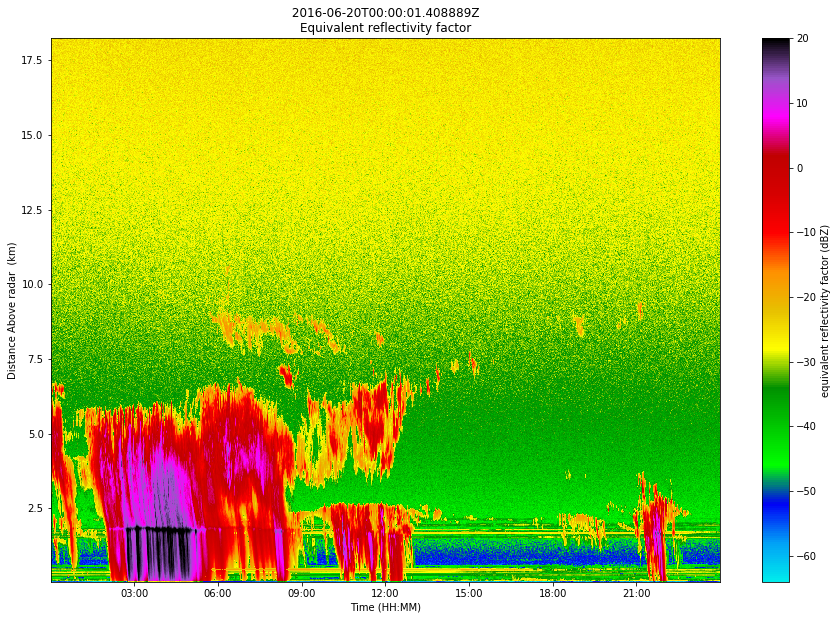

In [3]:
my_display = pyart.graph.RadarDisplay(radar)
my_fig = plt.figure(figsize = [15,10])

my_display.plot_vpt('reflectivity', vmin=-64, 
                    vmax=20, time_axis_flag=True)


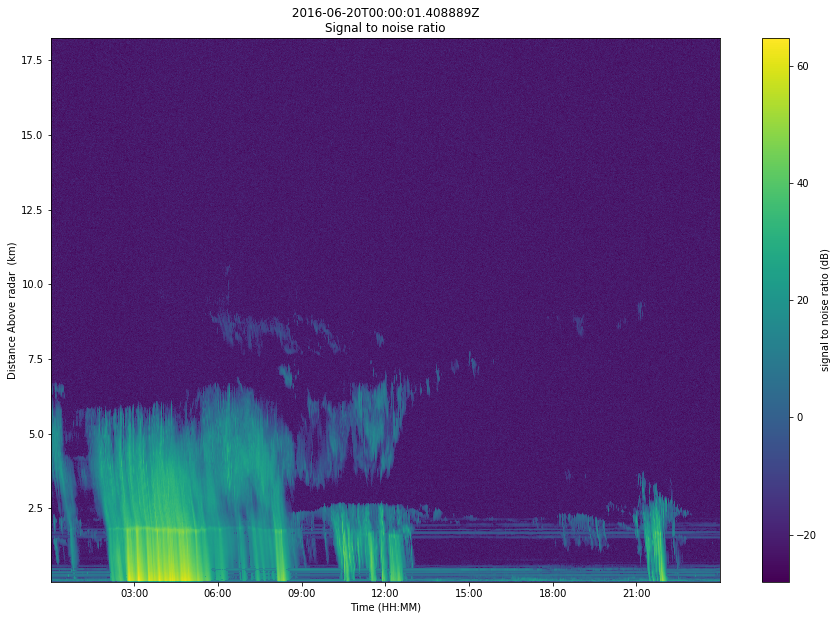

In [4]:
my_display = pyart.graph.RadarDisplay(radar)
my_fig = plt.figure(figsize = [15,10])

my_display.plot_vpt('snr_copol', time_axis_flag=True)


(0, 2.5)

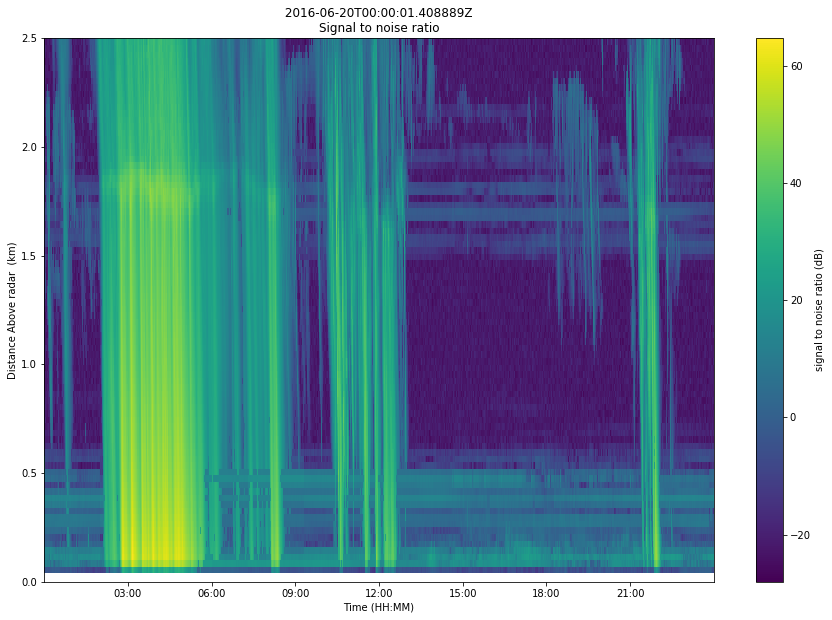

In [5]:
my_display = pyart.graph.RadarDisplay(radar)
my_fig = plt.figure(figsize = [15,10])

my_display.plot_vpt('snr_copol', time_axis_flag=True)

plt.ylim([0,2.5])

In [6]:
print(radar.fields.keys())

dict_keys(['co_to_crosspol_correlation_coeff', 'linear_depolarization_ratio', 'snr_xpol', 'mean_doppler_velocity', 'reflectivity', 'spectral_width', 'snr_copol'])


In [13]:
texture =  get_texture(radar)

700.886411190033


In [14]:
radar.add_field('velocity_texture', texture, replace_existing = True)

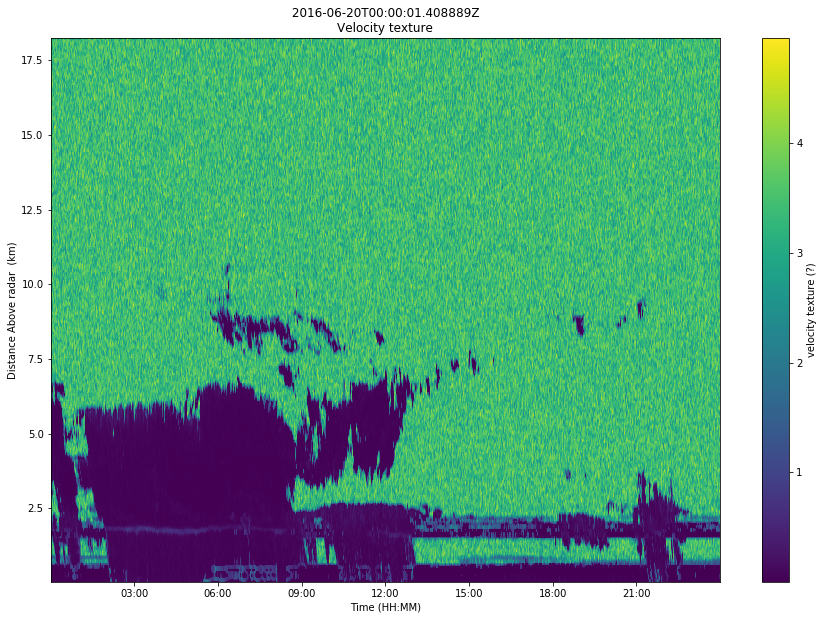

In [15]:
my_display = pyart.graph.RadarDisplay(radar)
my_fig = plt.figure(figsize = [15,10])

my_display.plot_vpt('velocity_texture', time_axis_flag=True)


In [17]:
n, bins = np.histogram(radar.fields['velocity_texture']['data'], bins = 150)
peaks = signal.find_peaks_cwt(n, np.array([10]))
centers = bins[0:-1] + (bins[1] - bins[0])
search_data = n[peaks[0]:peaks[1]]
search_centers = centers[peaks[0]:peaks[1]]
locs = search_data.argsort()
location_of_minima = locs[0]

1.91710291091


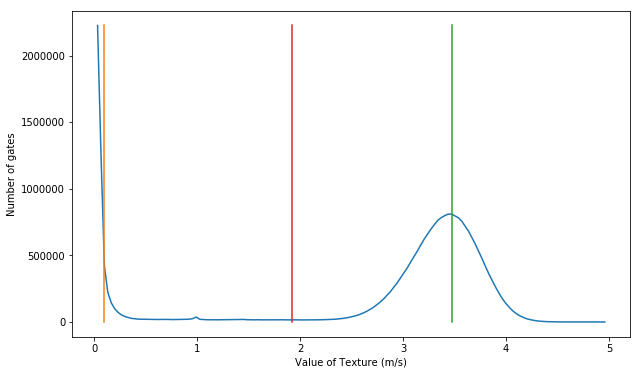

In [18]:
fig = plt.figure(figsize = [10,6])
plt.plot(centers, n)
zmax = n.max()
plt.plot([centers[peaks[0]], centers[peaks[0]]], [0, zmax])
plt.plot([centers[peaks[1]], centers[peaks[1]]], [0, zmax])
plt.plot([search_centers[location_of_minima], search_centers[location_of_minima]], [0, zmax])
noise_threshold = search_centers[locs[0]]
print(noise_threshold)
plt.xlabel('Value of Texture (m/s)')
plt.ylabel('Number of gates')

In [29]:
sig_dec = pyart.correct.GateFilter(radar)
sig_dec.exclude_all()
sig_dec.include_below('velocity_texture', 1.5)

In [32]:
#gatefilter can not be passed to VPT plot unlike PPI etc.. so doing this manualy
snr_data = copy.deepcopy(radar.fields['snr_copol']['data'])
snr_data_filt = np.ma.masked_where(sig_dec.gate_excluded, snr_data)
radar.add_field_like('snr_copol', 'snr_copol_filtered', snr_data_filt, replace_existing = True)

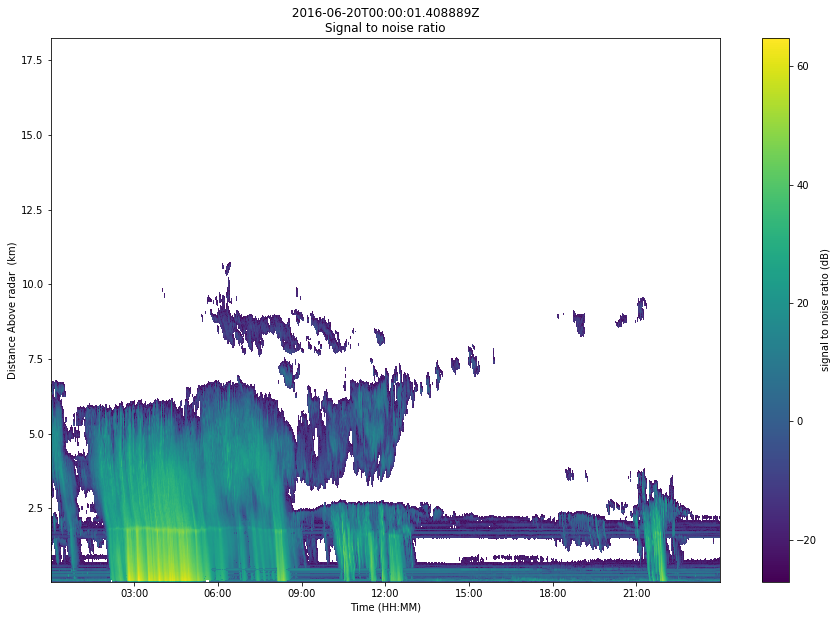

In [33]:
my_display = pyart.graph.RadarDisplay(radar)
my_fig = plt.figure(figsize = [15,10])

my_display.plot_vpt('snr_copol_filtered', time_axis_flag=True)


In [40]:
gates_sig = np.ones(radar.fields['snr_copol']['data'].shape)
gates_sig[sig_dec.gate_excluded] = 0.0
ngates_sig = gates_sig.sum(axis=1)

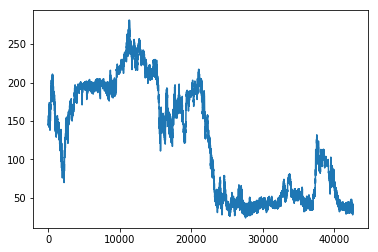

In [42]:
plt.plot(ngates_sig)

In [44]:
def mean_with_gatefilter(radar, field, gatefilter, reverse=False):
    field_data = radar.fields[field]['data']
    if reverse:
        masked_field_data = np.ma.masked_where(gatefilter.gate_included, field_data)
    else:
        masked_field_data = np.ma.masked_where(gatefilter.gate_excluded, field_data)
    return masked_field_data.mean(axis=1)
    

In [47]:
sig_returns = mean_with_gatefilter(radar, 'snr_copol', sig_dec)
bg_returns = mean_with_gatefilter(radar, 'snr_copol', sig_dec, reverse=True)

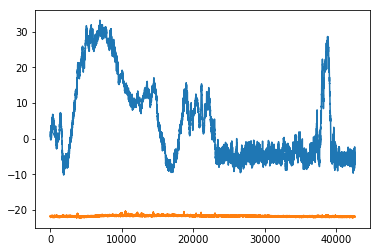

In [49]:
plt.plot(sig_returns)
plt.plot(bg_returns)


In [ ]:
nr, sr, br = kazr_tools.describe_radar(radar)

In [ ]:
print('hello)